# CAMO-Net – Exploratory Data Analysis (EDA)
## Camada GOLD – Modelo Dimensional

Este notebook examina os dados resultantes do pipeline **SILVER → GOLD**, incluindo:

### 🔹 Dimensões
- dim_tempo  
- dim_unidade_saude  
- dim_atendimento  
- dim_paciente  
- dim_medicamento  
- dim_diagnostico  

### 🔹 Fatos
- fato_prescricao  
- fato_diagnostico  
- fato_atendimento_resumo  

### Objetivos da EDA
1. Validar consistência geral da camada gold  
2. Entender padrões de prescrição, uso de antibióticos e diagnósticos infecciosos  
3. Explorar comportamento por faixa etária, unidade de saúde, especialidade e tempo  
4. Gerar insights epidemiológicos iniciais para dashboards e análises AMR  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

gold_path   = Path('../../data/gold/')

In [ ]:
dim_tempo       = pd.read_parquet(gold_path / 'dim_tempo.parquet')
dim_paciente    = pd.read_parquet(gold_path / 'dim_paciente.parquet')
dim_unidade     = pd.read_parquet(gold_path / 'dim_unidade_saude.parquet')
dim_medicamento = pd.read_parquet(gold_path / 'dim_medicamento.parquet')
dim_diagnostico = pd.read_parquet(gold_path / 'dim_diagnostico.parquet')
dim_atendimento = pd.read_parquet(gold_path / 'dim_atendimento.parquet')

In [4]:
f_presc  = pd.read_parquet(gold_path / 'fato_prescricao.parquet')
f_diag   = pd.read_parquet(gold_path / 'fato_diagnostico.parquet')
f_atend  = pd.read_parquet(gold_path / 'fato_atendimento_resumo.parquet')

f_presc.head()

,sk_prescricao,sk_atendimento,sk_paciente,sk_medicamento,sk_tempo,sk_unidade_saude,sk_diagnostico,quantidade,qtd_receita,duracao,concentracao,e_antibiotico,e_diagnostico_infeccioso,e_prescricao_apropriada,e_prescricao_inadequada,tipo_uso,espectro_acao,classe_who_aware
0,1,2524,35622,126,53,48,545.0,20,1,TOMAR 1 COMP 12/12 HORAS,500MG,1,1,True,False,None,Específico,Not Classified
1,2,1019,53759,597,157,47,NaN,1,1,PELA BOCA: 10 ML 8/8 HORAS - 7 DIAS,250 MG,1,1,True,False,None,Específico,Not Classified
2,3,1890,14865,597,130,47,NaN,1,1,"PELA BOCA: 7,5 ML 8/8 HORAS - 7 DIAS",250 MG,1,1,True,False,None,Específico,Not Classified
3,4,3253,24993,597,106,47,NaN,1,1,PELA BOCA: 10 ML 8/8 HORAS - 7 DIAS,250 MG,1,1,True,False,None,Específico,Not Classified
4,5,3880,24559,597,185,47,NaN,1,1,PELA BOCA: 10 ML 8/8 HORAS - 7 DIAS,250 MG,1,1,True,False,None,Específico,Not Classified


In [16]:
dim_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data_completa  221 non-null    datetime64[ns]
 1   sk_tempo       221 non-null    int64         
 2   ano            221 non-null    int32         
 3   mes            221 non-null    int32         
 4   trimestre      221 non-null    int32         
 5   semestre       221 non-null    int64         
 6   dia_semana     221 non-null    int32         
 7   nome_mes       221 non-null    object        
 8   ano_mes        221 non-null    object        
dtypes: datetime64[ns](1), int32(4), int64(2), object(2)
memory usage: 12.2+ KB


### 🔍 Parte 1 — Verificações Rápidas

In [5]:
tamanhos = {
    "dim_tempo": len(dim_tempo),
    "dim_paciente": len(dim_paciente),
    "dim_unidade": len(dim_unidade),
    "dim_medicamento": len(dim_medicamento),
    "dim_diagnostico": len(dim_diagnostico),
    "dim_atendimento": len(dim_atendimento),
    "f_prescricao": len(f_presc),
    "f_diagnostico": len(f_diag),
    "f_atendimento_resumo": len(f_atend)
}

pd.DataFrame.from_dict(tamanhos, orient="index", columns=["registros"])


,registros
dim_tempo,221
dim_paciente,67023
dim_unidade,50
dim_medicamento,33246
dim_diagnostico,1483
dim_atendimento,224157
f_prescricao,306318
f_diagnostico,298848
f_atendimento_resumo,224157


In [6]:
missing_df = f_presc.isna().mean().sort_values(ascending=False)
missing_df.to_frame("percent_missing").head(15)


,percent_missing
tipo_uso,1.000000
sk_diagnostico,0.096047
sk_prescricao,0.000000
concentracao,0.000000
espectro_acao,0.000000
e_prescricao_inadequada,0.000000
e_prescricao_apropriada,0.000000
e_diagnostico_infeccioso,0.000000
e_antibiotico,0.000000
duracao,0.000000


### 📊 Parte 2 — EDA de Prescrição (Fato Principal)

In [7]:
taxa_atb = f_presc['e_antibiotico'].mean() * 100
taxa_adequada = f_presc['e_prescricao_apropriada'].mean() * 100
taxa_inadequada = f_presc['e_prescricao_inadequada'].mean() * 100

taxa_atb, taxa_adequada, taxa_inadequada


(2.671080380519591, 1.2176888070567187, 1.453391573462872)

/tmp/ipykernel_63103/3408619189.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=f_presc, x='classe_who_aware', palette='viridis')


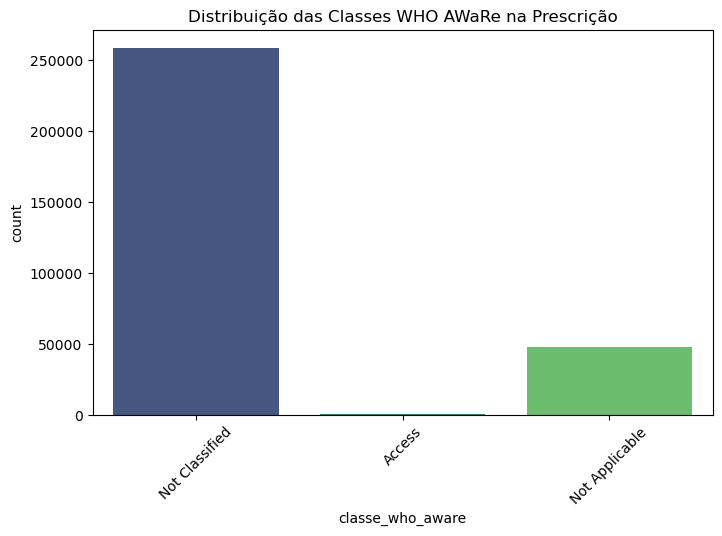

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(data=f_presc, x='classe_who_aware', palette='viridis')
plt.title("Distribuição das Classes WHO AWaRe na Prescrição")
plt.xticks(rotation=45)
plt.show()


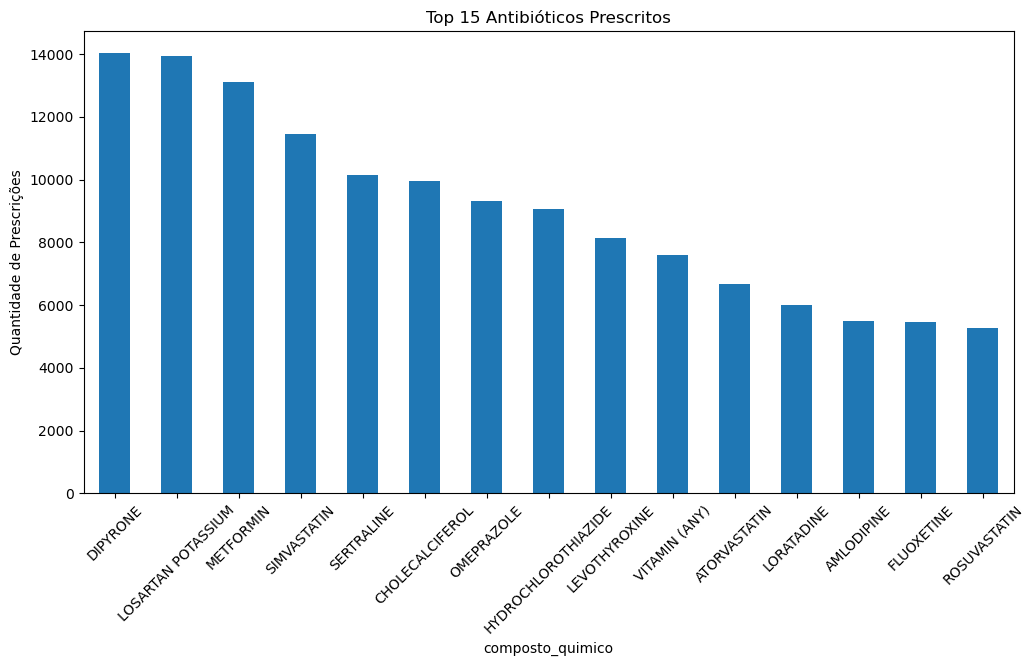

In [9]:
top_med = (
    f_presc.merge(dim_medicamento[['sk_medicamento','composto_quimico']])
           .groupby('composto_quimico').size()
           .sort_values(ascending=False)
           .head(15)
)

top_med.plot(kind='bar', figsize=(12,6))
plt.title("Top 15 Antibióticos Prescritos")
plt.ylabel("Quantidade de Prescrições")
plt.xticks(rotation=45)
plt.show()


### 🧬 Parte 3 — Padrões Epidemiológicos

In [10]:
df_plot = (
    df_esp
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(14, 20))
sns.barplot(
    data=df_plot,
    y='especialidade',
    x='e_diag_infeccioso',
    orient='h',
    palette='viridis'
)
plt.title("Percentual de Diagnósticos Infecciosos por Especialidade")
plt.xlabel("% Infecções")
plt.ylabel("Especialidade")
plt.tight_layout()
plt.show()


NameError: name 'df_esp' is not defined

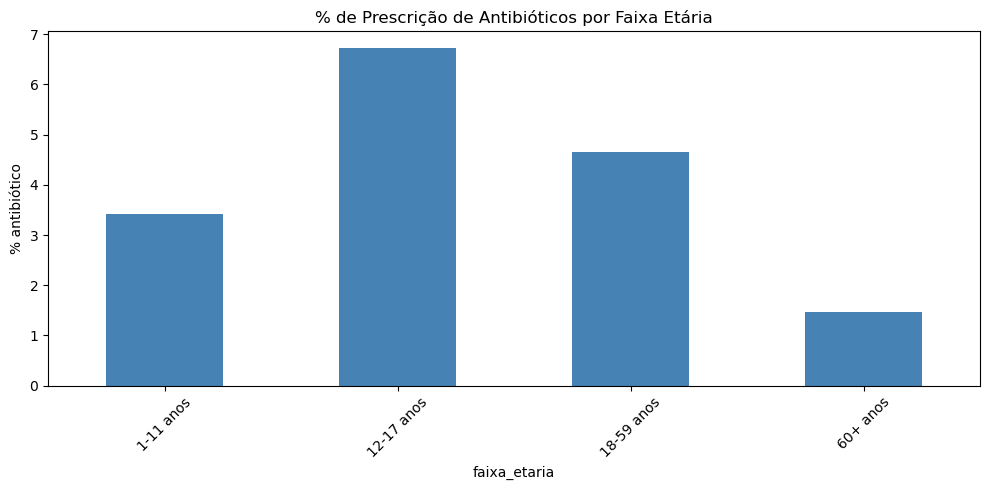

In [56]:
plt.figure(figsize=(10,5))

df_faixa.plot(
    kind='bar',
    figsize=(10,5),
    color='steelblue',
)

plt.title("% de Prescrição de Antibióticos por Faixa Etária")
plt.ylabel("% antibiótico")
plt.xlabel("faixa_etaria")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### 🏥 Parte 4 — Unidades de Saúde

In [63]:
df_un = (
    f_presc
        .merge(
            dim_unidade[['sk_unidade_saude', 'cod_unidade_saude', 'nome_unidade']],
            on='sk_unidade_saude',
            how='left'
        )
        .groupby('nome_unidade')['e_antibiotico']
        .mean()
        .sort_values(ascending=False) * 100
)

df_un

nome_unidade
SAD - PROGRAMA DE ATENCAO DOMICILIAR      4.721030
UBS MARIA CORBETA SEGATTO                 4.461843
UBS DOLORES MASSEI                        3.704130
CENTRO DE ESPECIALIDADES MEDICAS - CEM    2.854071
UBS NAIR SPINA BENEDICTIS                 2.833596
CENTRO POLICLINICO GENTIL RSTOM           2.787221
UBS DR ANGELO ANTENOR ZAMBOM              2.664997
UBS AMELIA RICHARD LOCATELLI              2.634847
UBS DR IVANHOE ESPOSITO                   2.506012
UBS MOACIR GALLINA                        2.336497
UBS DARCY SARMANHO VARGAS                 2.300633
UBS CATERINA DALLANESE                    2.213536
UBS JOAO LUIZ PASQUAL BONAPARTE           0.969838
Name: e_antibiotico, dtype: float64

### 🗓 Parte 5 — Séries Temporais

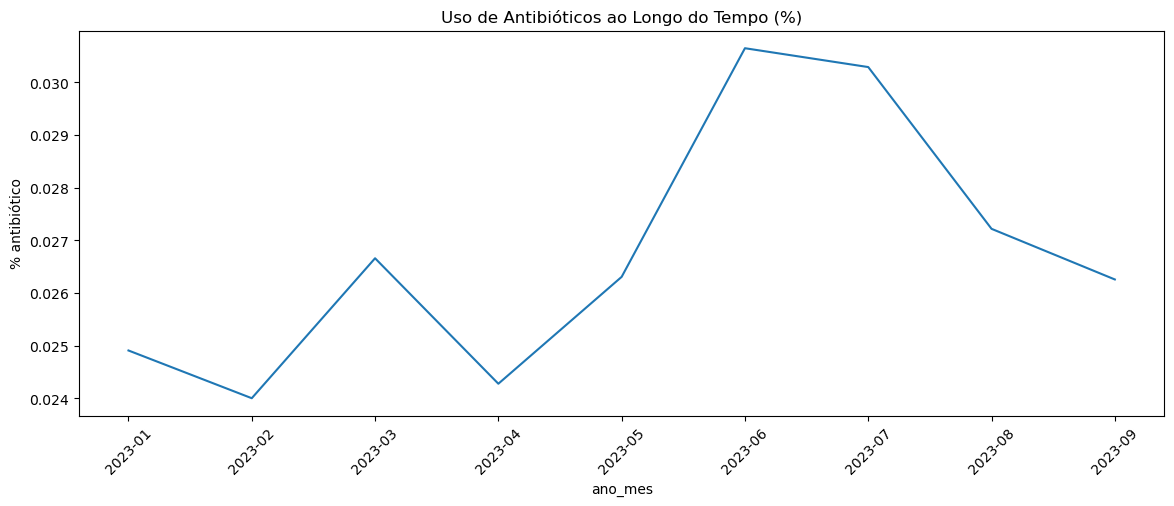

In [64]:
df_time = (
    f_presc.merge(dim_tempo[['sk_tempo','ano_mes']])
           .groupby('ano_mes')['e_antibiotico']
           .mean()
           .reset_index()
)

plt.figure(figsize=(14,5))
sns.lineplot(data=df_time, x='ano_mes', y='e_antibiotico')
plt.xticks(rotation=45)
plt.title("Uso de Antibióticos ao Longo do Tempo (%)")
plt.ylabel("% antibiótico")
plt.show()


### 📌 Parte 6 — Análise Combinada (Prescrição Apropriada vs Demografia)

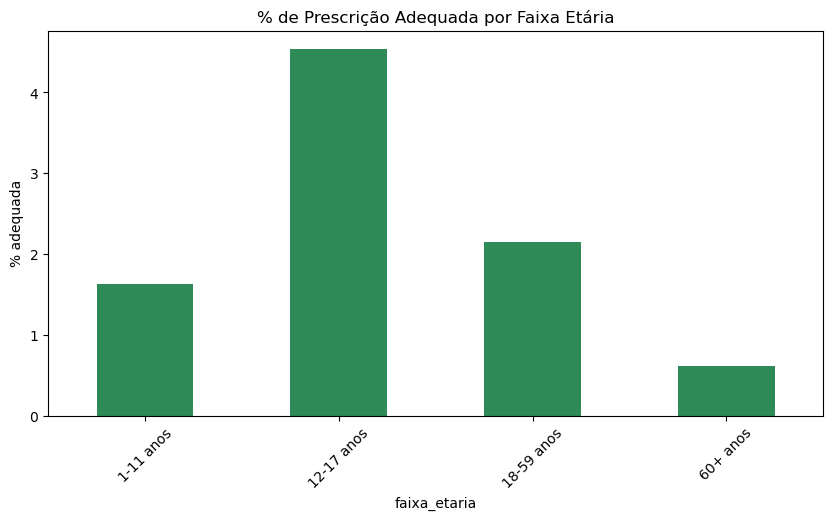

In [16]:
df_faixa_ap = (
    f_presc.merge(dim_paciente[['sk_paciente','faixa_etaria']])
           .groupby('faixa_etaria')['e_prescricao_apropriada']
           .mean() * 100
)

df_faixa_ap.plot(kind='bar', figsize=(10,5), color='seagreen')
plt.title("% de Prescrição Adequada por Faixa Etária")
plt.ylabel("% adequada")
plt.xticks(rotation=45)
plt.show()


# Conclusões Preliminares

- A proporção de prescrições de antibióticos é __X%__  
- A taxa de prescrição inadequada é __Y%__ (antibiótico sem infecção)  
- Faixas etárias __A e B__ concentram maior uso de antibióticos  
- As unidades __U1–U2__ apresentam maior proporção de antibiótico  
- Diagnósticos infecciosos são mais frequentes em __especialidades S__  
- A curva temporal mostra tendência __(crescente / estável / sazonal)__  
